## 2 Perceptron vs Neural Networks

Working on a binary classification task on a given synthetic dataset. Use machine learning tools including a Perceptron and a 3-layer Neural Network to solve the task.

### I plot the training and testing data separately in two plots

In [1]:
#import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#get files
with open('Task2B_train.csv', 'r') as file1:
    train = file1.readlines()

with open('Task2B_test.csv', 'r') as file2:
    test = file2.readlines()

In [3]:
#function to split data and represent in dataframe
def sep_data(x):
    columns = x[0].split(',')
    data = x[1:]
    
    data_sep = []
    for line in data:
        data_sep.append(line.split(','))
    
    data_sep = [list(map(float, l)) for l in data_sep]
    
    df = pd.DataFrame(data_sep, columns = columns)
    return df

In [4]:
# create train and test dataframes
pd_train = sep_data(train)
pd_test = sep_data(test)

In [5]:
pd_train.head()

,feature1,feature2,label\n
0,1.517571,0.424917,1.0
1,0.304268,0.999691,0.0
2,0.485924,-0.222913,1.0
3,-0.933579,-0.093579,0.0
4,0.684210,-0.436912,1.0


In [6]:
#plot function to get label colors
#limit allows partial data plotting for troubleshooting
def plot_(x, y, label, limit, axis):
    for i in range(2):
        ax[axis].scatter(x[:limit][label==i], y[:limit][label==i], c=('blue' if i==0 else 'red'), 
                         label=i, alpha=0.5)

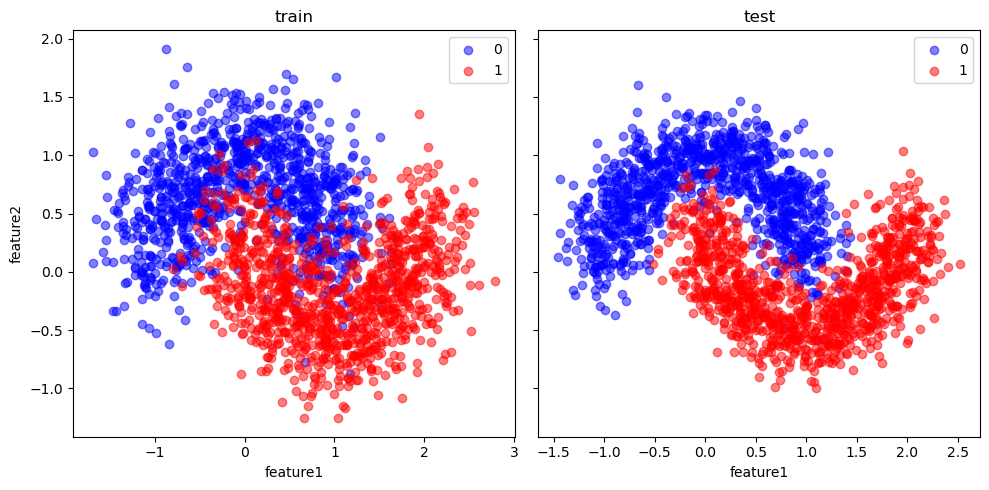

In [7]:
#plot data
_, ax = plt.subplots(1, 2, figsize=(10,5), tight_layout=True, sharey=True)

plot_(pd_train.feature1, pd_train.feature2, pd_train['label\n'], limit=None, axis=0)
plot_(pd_test.feature1, pd_test.feature2, pd_test['label\n'], limit=None, axis=1)

for i in range(2):
    ax[i].set_title('train' if i==0 else'test')
    ax[i].set_xlabel('feature1')
    ax[i].legend()
ax[0].set_ylabel('feature2')
plt.show()

### II Train two Perceptron models on the loaded training data

In [8]:
class Perceptron:
    
    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape

        self.w_trace_ = np.empty((self.tau_max, p))     # trace of weights during training
        self.xy_idx_trace_ = np.empty(self.tau_max, int) # trace of considered training point indices
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0,:] = RNG.normal(size=p) 
        terminate = False
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n), size = n, replace = False)
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    #update w using formula w <- w + (2t_n - 1) * eta * x_n
                    self.w_ = self.w_ + (2*y[order][i]-1)*self.eta * x[order][i]
                
                self.w_trace_[tau+1] = self.w_
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        return (x.dot(self.w_) >= 0).astype(int)


In [9]:
#format test/train variables for perceptron
x_train = np.asarray(list(zip(pd_train.feature1, pd_train.feature2)))
x_test = np.asarray(list(zip(pd_test.feature1, pd_test.feature2)))
y_train = pd_train['label\n']
y_test = pd_test['label\n']

In [10]:
from sklearn.metrics import zero_one_loss

#function to calculate test errors for given eta
def test_eta(eta, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, random_state=None):
    #fit train data
    perceptron = Perceptron(eta=eta, random_state=random_state)
    perceptron.fit(x_train, y_train)
    
    #get test error rates 
    test_err = zero_one_loss(perceptron.predict(x_test), y_test)
    
    return f'eta:{eta} test_err:{round(test_err,4)}'

In [11]:
#calculate test errors for eta 0.01 and 0.1
test_eta(0.01, random_state=0), test_eta(0.1, random_state=0)

('eta:0.01 test_err:0.2545', 'eta:0.1 test_err:0.143')

#### Find the best η and its corresponding model, then plot the decision boundary and the test data in one plot

Best $\eta$ is 0.1 as this results in the lowest test error as demonstrated above

In [12]:
#Train perceptron with best eta
perceptron = Perceptron(eta=0.1, random_state=0)
perceptron.fit(x_train, y_train)

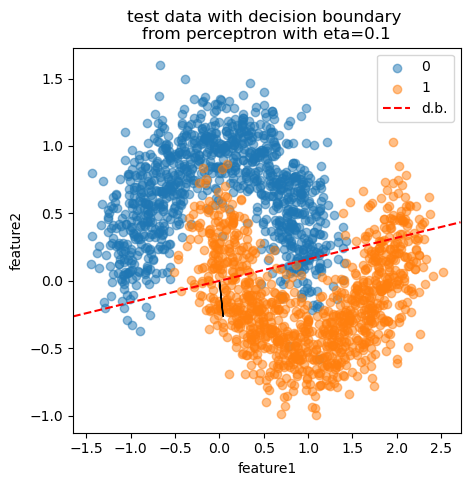

In [13]:
#plot test data and perceptron decision boundary
def plot_line(slope, intercept, ax=None, shape='--', **kwargs):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    ax.plot(x_vals, y_vals, shape, **kwargs)
    
def plot_decision_boundary_from_weights(weights, intercept=0, ax=None):
    slope = -weights[0]/weights[1]
    plot_line(slope, intercept, ax, shape='--', color='red', label='d.b.')

plt.figure(figsize=(5, 5))

for i in range(2):
    plt.scatter(x_test[y_test==i][:,0], x_test[y_test==i][:,1], label=i, alpha=0.5)

plot_decision_boundary_from_weights(perceptron.w_)
plt.arrow(0, 0, *(perceptron.w_*2))
plt.title('test data with decision boundary \nfrom perceptron with eta=0.1')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend()
plt.show()

### III For each combination of K and η run the 3-layer Neural Network and record testing error for each of them

In [55]:
class NNet():
    
    def __init__(self, K=3, epoch_max=1000, eta=0.1, alpha=0.001):
        # Setting parameters
        self.K = K # number of units in the hidden layer
        self.epoch_max = epoch_max # maximum number of iterations
        self.eta = eta # learning rate
        self.alpha = alpha # regularization term
    
    ## the activation function (sigmoid here)
    def h(self, z):
        return (1/(1+np.exp(-3*z)))

    ## the derivitive of the activation function (sigmoid here)
    def h_d(self, z):
        return (self.h(z)*(1-self.h(z)))

    ## Accuracy
    def accuracy(self, pred, label):
        return (pred == label).mean()
    
    def feedforward(self, Xi, Ti):
        ### 1st (input) layer 
        a1 = Xi                           
        y = Ti                          
        ### 2nd (hidden) layer
        z2 = a1 @ self.W1 + self.b1                            
        a2 = self.h(z2)                                  
        ### 3rd (output) layer
        z3 = a2 @ self.W2 + self.b2                         
        a3 = self.h(z3)                            
        return(a1, a2, a3, y, z2, z3)

    def backpropagation(self, Ti, z2, z3, a3):
        ### 3rd (output) layer
        d3 = -(Ti-a3) * self.h_d(z3)                          
        ### 2nd (hidden) layer
        d2 =  (d3 @ self.W2.T) * self.h_d(z2)                          
        return(d2,d3)

    def predict(self, X, threshold=0.5):
        # we use the feedforward network we defined to obtain output activation (a3)
        _,_, a3,_,_,_ = self.feedforward(X, 1)
        return np.array([1 if above_thresh else 0 for above_thresh in (a3 >= threshold)]).reshape(-1,1)
    

    def train_test(self, X1, X2, T1, T2, seed=None):
        if seed is not None: np.random.seed(seed)
        # Setting parameters
        N,D = X1.shape

        # initialization
        epoch = 1 # epoch (iteration) counter
        terminate = False   # termination criteria

        ## weight vectors/matrices initialization
        ### w stands for weight and b for bias
        ### the numbers after the letters indicates the layer number
        self.W1 = np.random.normal(scale=0.5, size=(D,self.K)) * 0.01
        self.b1 = np.zeros((1,self.K))
        self.W2 = np.random.normal(scale=0.5, size=(self.K,1)) * 0.01
        self.b2 = np.zeros((1,1))
        ## tracing accuracy of the model 
        train_accuracy = []
        test_accuracy = []

        # main loop
        while (not terminate):

            ## Feedforward:
            a1, a2, a3, y, z2, z3 = self.feedforward(X1, T1)

            ## Backpropagation:
            d2, d3 = self.backpropagation(T1, z2, z3, a3)

            ## calculate the delta values
            ### 1st layer
            W1_d = a1.T @ d2
            b1_d = d2
            ### 2nd layer
            W2_d = a2.T @ d3
            b2_d = d3

            ## update weight vectors and matrices
            ### 1st (input) layer
            self.W1 = self.W1 - self.eta * (W1_d/N + self.alpha*self.W1)
            self.b1 = self.b1 - self.eta * (b1_d.mean(axis=0, keepdims=True))
            ### 2nd (hidden) layer
            self.W2 = self.W2 - self.eta * (W2_d/N + self.alpha*self.W2)
            self.b2 = self.b2 - self.eta * (b2_d.mean(axis=0, keepdims=True))

            ## trace train and test accuracy
            train_accuracy.append(self.accuracy(self.predict(X1), T1))
            test_accuracy.append(self.accuracy(self.predict(X2), T2))
            ## increase the iteration counter
            epoch = epoch + 1

            ## check the termination criteria
            if (epoch >= self.epoch_max): terminate = True
        
        return (train_accuracy,test_accuracy)

In [59]:
#set variables to pass to neural network
X1, X2, T1, T2 = x_train, x_test, y_train, y_test

T1 = np.asarray(T1).reshape(-1, 1)
T2 = np.asarray(T2).reshape(-1, 1)

In [60]:
#define k and eta ranges
ks = np.arange(5, 45, 5)
etas = [0.01, 0.001]

Training..
k=5 eta=0.01
k=10 eta=0.01
k=15 eta=0.01
k=20 eta=0.01
k=25 eta=0.01
k=30 eta=0.01
k=35 eta=0.01
k=40 eta=0.01
k=5 eta=0.001
k=10 eta=0.001
k=15 eta=0.001
k=20 eta=0.001
k=25 eta=0.001
k=30 eta=0.001
k=35 eta=0.001
k=40 eta=0.001


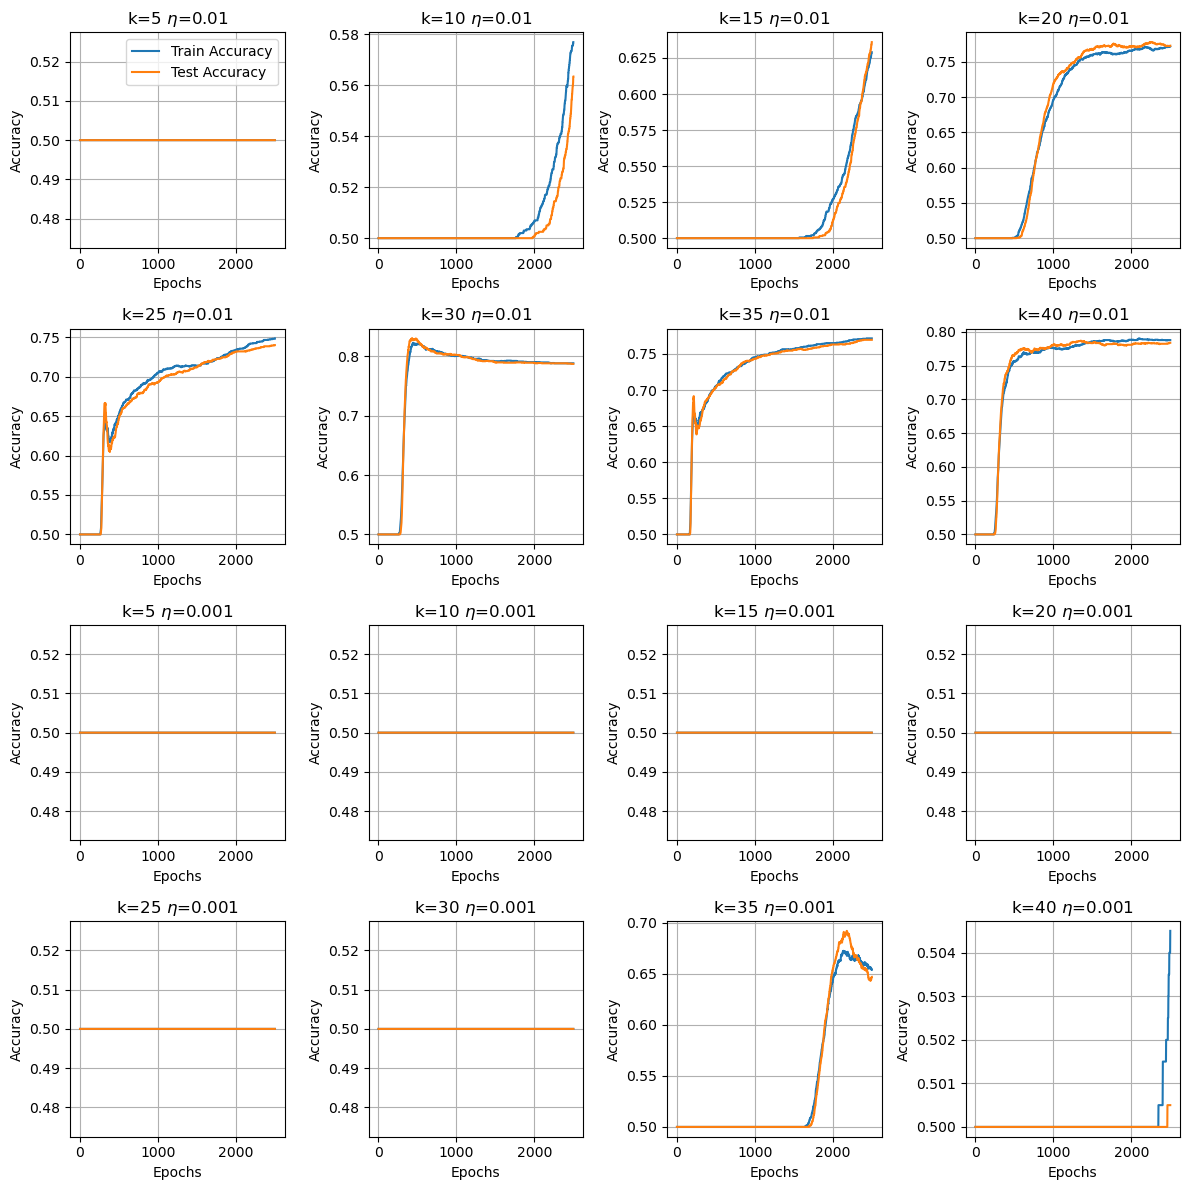

In [17]:
#train and test model across range of k and eta and plot performance results
fig, axs = plt.subplots(4, 4, tight_layout=True)
fig.set_figwidth(12)
fig.set_figheight(12)

test_err = []
i=-1
print('Training..')
for eta in etas:
    for j, k in enumerate(ks):
        print(f'k={k} eta={eta}')
        nnet = NNet(K=k, epoch_max=2500, eta=eta)
        train, test = nnet.train_test(X1, X2, T1, T2, seed=55)
        if j%4==0: i += 1
        if j>=4: j -= 4
        axs[i, j].plot(range(len(train)), train, label='Train Accuracy')
        axs[i, j].plot(range(len(test)), test, label='Test Accuracy')
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].grid()
        axs[i, j].set_ylabel('Accuracy')
        axs[i, j].set_title(f'k={k} $\eta$={eta}')
        test_err.append(test)
axs[0, 0].legend()
plt.show()

#### Find the best combination of K and η and obtain the best model, then plot the decision boundary and the test data in one plot.

The best accuracy appears to be at k=30, $\eta$=0.01

In [61]:
#train NN model using best params
K, eta = 30, 0.01
nn_model = NNet(K=K, epoch_max=2500, eta=eta)
_, _ = nn_model.train_test(X1, X2, T1, T2, seed=55)

In [46]:
#use grid of full dataset in order to plot NN decision boundary
dataset = pd.concat([pd_train, pd_test])
len(dataset)
x = np.asarray(list(zip(dataset.feature1, dataset.feature2)))
y = np.asarray(dataset['label\n'])
x.shape, y.shape

((4000, 2), (4000,))

In [66]:
#function to plot NN decision boundary using grid representation
def plot_grid(model, x, x_test, y_test, padding=0):
    x1_min, x1_max = x[:,0].min() -padding, x[:,0].max() +padding
    x2_min, x2_max = x[:,1].min() -padding, x[:,1].max() +padding
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contour(xx, yy, Z, levels=[0.5], colors='red', linestyles='dashed')
    
    #plot test data
    for i in range(2):
        plt.scatter(x_test[y_test==i][:,0], x_test[y_test==i][:,1], label=i, alpha=0.5)

    plt.title(f'test data with decision boundary \nfrom neural network with K={K}, $\eta$={eta}')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.legend()
    plt.show()

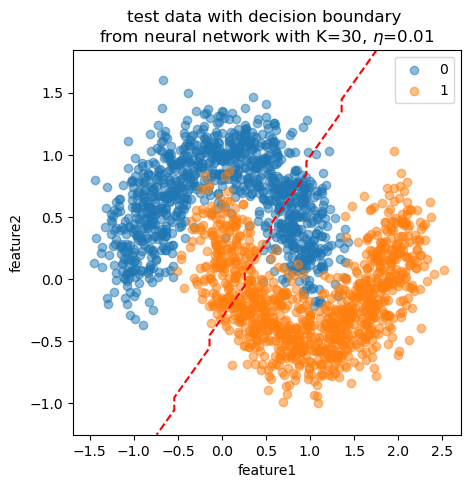

In [63]:
plot_grid(nn_model, x, x_test, y_test)

#### Differences between Perceptron and a 3-layer Neural Network

**NOTE: There appears to be an issue with our neural network implementation as we expect to see a non-linear function in the above plot. To complete the activity MLPClassifier is imported below in order to have valid data for analysis.**

In [64]:
from sklearn.neural_network import MLPClassifier
X1, T1 = x_train, y_train
nn_model2 = MLPClassifier(solver='adam', learning_rate_init=0.01, hidden_layer_sizes=(30), random_state=55, 
                            max_iter=2500)
nn_model2.fit(X1, T1)

MLPClassifier(hidden_layer_sizes=30, learning_rate_init=0.01, max_iter=2500,
              random_state=55)

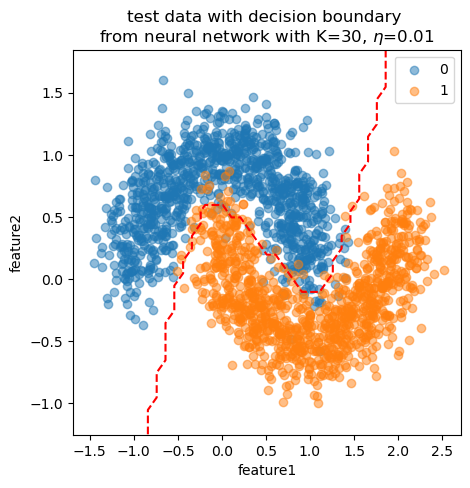

In [65]:
plot_grid(nn_model2, x, x_test, y_test)

Looking at the perceptron and 3-layer neural network plots the most obvious contrast is the linearity of the decision boundaries, which reflects the fudamentally different nature of the two algorithms. 

The perceptron can be thought of as a single layer neural network that determines the decision boundary using the weighted sum of inputs that are put through a binary activation/step function to determine classification.  This model is not capable of modelling complex non-linear functions and therefore attempts to fit a straight line through the data (as seen in the perceptron plot). This is not very accurate given that the data is not linearly separable and therefore not conducive to this approach. 

In contrast neural networks use continuous activation functions like sigmoid or tan functions and combine multiple neurons to map complex relationships. This enables them to determine non-linear decision boundaries like the one in the plot above. As we can see this is a far more accurate classificaiton of the dataset.